In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray
import os
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd

In [2]:
paths_list=['raw_data/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_1985.nc']
uru = gpd.read_file("ury_adm_2020_shp.zip")

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'ury_adm_2020_shp.zip': 'ury_admbnda_adm0_2020' (default), 'ury_admbnda_adm1_2020', 'ury_admbnda_adm2_2020', 'ury_admbndl_ALL_2020'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
def filter_precip(paths,shape):
    for path in paths:
        #Open and fix files
        filename = os.path.splitext(os.path.basename(path))[0]
        
        data = os.path.join(path)
        ds_GDDP6 = xr.open_dataset(data)
        ds_GDDP6 = ds_GDDP6.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
        ds_GDDP6.rio.write_crs("epsg:4326", inplace=True)
        ds_GDDP6.coords['lon'] = (ds_GDDP6.coords['lon'] + 180) % 360 - 180
        ds_GDDP6 = ds_GDDP6.sortby(ds_GDDP6.lon)

        #Filter Uruguay data
        ds_GDDP6 = ds_GDDP6.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
        ds_masked = ds_GDDP6.rio.clip(shape.geometry, shape.crs, drop=True)
        secs_in_a_day = 24*60*60
        ds_masked['pr_mmd'] = (ds_masked['pr']*secs_in_a_day).round(2).astype('float32')
        ds_masked.to_netcdf(f"filtered_data/{filename}_masked.nc")

        ds_GDDP6.close()
        ds_masked.close()

In [4]:
# filter_precip(paths_list,uru)

In [5]:
# paths_filtered=['filtered_data/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_1985_masked.nc']

In [6]:
def means(paths):
    for path in paths:
        data = os.path.join(path)
        ds_masked = xr.open_dataset(data)
        
        # Create a new coordinate 'year_month' by extracting the year and month
        ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

        # Group by the new 'year_month' coordinate and aggregate (e.g., sum)
        ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)

        # Compute the spatial mean of 'pr_mmd' for each month
        ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'],skipna=True)
    
    return ds_monthly_spatial_mean

In [7]:
# trying=means(paths_filtered)

In [8]:
# trying

In [9]:
# trying_df=trying.to_dataframe()
# trying_df.head()

In [10]:
def means_plot(paths,month):
    for path in paths:
        data = os.path.join(path)
        ds_masked = xr.open_dataset(data)
        
        # Create a new coordinate 'year_month' by extracting the year and month
        ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

        # Group by the new 'year_month' coordinate and aggregate (e.g., sum)
        ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)

        # Compute the spatial mean of 'pr_mmd' for each month
        ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'],skipna=True)

        # min_mmd=ds_masked['pr_mmd'].min().item()
        # max_mmd=ds_masked['pr_mmd'].max().item()

        fig, ax = plt.subplots()

        ds_monthly['pr_mmd'].isel(year_month=month).plot(ax=ax) #,vmin=min_mmd,vmax=max_mmd)
        uru.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
        plt.show()

In [11]:
paths_filtered=['filtered_data/pr_day_TaiESM1_historical_r1i1p1f1_gn_1985_masked.nc']

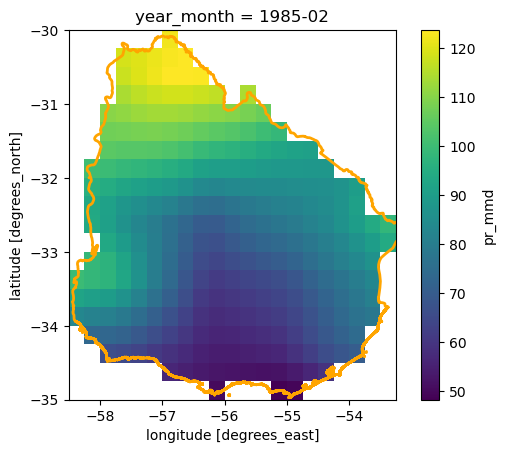

In [12]:
means_plot(paths_filtered,month=1)

In [13]:
def means_dataframe(folder, model_name=None, scenario=None):
    dataframes = []

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (model_name is None or model_name in file) and (scenario is None or scenario in file):
            ds_masked = xr.open_dataset(file_path)
            ds_masked = ds_masked.assign_coords(year_month=ds_masked.time.dt.strftime('%Y-%m'))
            ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)
            ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'], skipna=True)
            dataframes.append(ds_monthly_spatial_mean.to_dataframe())

    result=pd.concat(dataframes)
    result=result.sort_values('year_month')
    
    return result

In [14]:
EC_Earth3_historical=means_dataframe('filtered_data', model_name='EC-Earth3_', scenario='historical')

In [15]:
EC_Earth3_historical.head()

,pr_mmd
year_month,
1985-01,105.662392
1985-02,195.010895
1985-03,37.098259
1985-04,144.234116
1985-05,110.781372


In [16]:
TaiESM1_historical=means_dataframe('filtered_data', model_name='TaiESM1', scenario='historical')

In [17]:
EC_Earth3_ssp126=means_dataframe('filtered_data', model_name='EC-Earth3_', scenario='ssp126')

In [18]:
TaiESM1_ssp126=means_dataframe('filtered_data', model_name='TaiESM1', scenario='ssp126')

In [19]:
EC_Earth3_ssp126.head()

,pr_mmd
year_month,
2025-01,50.786198
2025-02,73.002831
2025-03,131.339279
2025-04,77.298729
2025-05,76.932648


In [20]:
#Split data into future 1 and future 2
EC_Earth3_ssp126_2544=EC_Earth3_ssp126.loc['2025-01':'2044-12']
EC_Earth3_ssp126_4564=EC_Earth3_ssp126.loc['2025-01':'2044-12']
TaiESM1_ssp126_2544=TaiESM1_ssp126.loc['2025-01':'2044-12']
TaiESM1_ssp126_4564=TaiESM1_ssp126.loc['2025-01':'2044-12']

In [21]:
# EC_Earth3_quintile_0=EC_Earth3_historical.quantile(0).item()
# EC_Earth3_quintile_02=EC_Earth3_historical.quantile(0.2).item()
# EC_Earth3_quintile_04=EC_Earth3_historical.quantile(0.4).item()
# EC_Earth3_quintile_06=EC_Earth3_historical.quantile(0.6).item()
# EC_Earth3_quintile_08=EC_Earth3_historical.quantile(0.8).item()
# EC_Earth3_quintile_1=EC_Earth3_historical.quantile(1).item()

In [22]:
# EC_Earth3_quintile_0

In [23]:
# year_month=EC_Earth3_ssp126_2544.index.tolist()
# year_month[:5]

In [24]:
# for i in year_month:
#     pr=EC_Earth3_ssp126_2544.at[i, 'pr_mmd']
#     if pr<EC_Earth3_quintile_0:
#         EC_Earth3_ssp126_2544.at[i, 'pr_cat']=0
#     elif  EC_Earth3_quintile_0 <= pr < EC_Earth3_quintile_02:
#         EC_Earth3_ssp126_2544.at[i, 'pr_cat']=1
#     elif  EC_Earth3_quintile_02 <= pr < EC_Earth3_quintile_04:
#         EC_Earth3_ssp126_2544.at[i, 'pr_cat']=2
#     elif  EC_Earth3_quintile_04 <= pr < EC_Earth3_quintile_06:
#         EC_Earth3_ssp126_2544.at[i, 'pr_cat']=3
#     elif  EC_Earth3_quintile_06 <= pr < EC_Earth3_quintile_08:
#         EC_Earth3_ssp126_2544.at[i, 'pr_cat']=4
#     elif  EC_Earth3_quintile_08 <= pr < EC_Earth3_quintile_1:
#         EC_Earth3_ssp126_2544.at[i, 'pr_cat']=5
#     elif  pr > EC_Earth3_quintile_1:
#         EC_Earth3_ssp126_2544.at[i, 'pr_cat']=6

In [25]:
# EC_Earth3_ssp126_2544

In [26]:
def clasification(historical_dataframe,dataframe):
    quintile_0=historical_dataframe.quantile(0).item()
    quintile_02=historical_dataframe.quantile(0.2).item()
    quintile_04=historical_dataframe.quantile(0.4).item()
    quintile_06=historical_dataframe.quantile(0.6).item()
    quintile_08=historical_dataframe.quantile(0.8).item()
    quintile_1=historical_dataframe.quantile(1).item()
    
    year_month=dataframe.index.tolist()
    for i in year_month:
        pr=dataframe.loc[i, 'pr_mmd']
        if pr<quintile_0:
            dataframe.loc[i, 'pr_cat']=0
        elif  quintile_0 <= pr < quintile_02:
            dataframe.loc[i, 'pr_cat']=1
        elif  quintile_02 <= pr < quintile_04:
            dataframe.loc[i, 'pr_cat']=2
        elif  quintile_04 <= pr < quintile_06:
            dataframe.loc[i, 'pr_cat']=3
        elif  quintile_06 <= pr < quintile_08:
            dataframe.loc[i, 'pr_cat']=4
        elif  quintile_08 <= pr < quintile_1:
            dataframe.loc[i, 'pr_cat']=5
        elif  pr > quintile_1:
            dataframe.loc[i, 'pr_cat']=6
    return dataframe

In [27]:
EC_Earth3_ssp126_2544=clasification(EC_Earth3_historical,EC_Earth3_ssp126_2544)
EC_Earth3_ssp126_4564=clasification(EC_Earth3_historical,EC_Earth3_ssp126_4564)
TaiESM1_ssp126_2544=clasification(TaiESM1_historical,EC_Earth3_ssp126_2544)
TaiESM1_ssp126_4564=clasification(TaiESM1_historical,TaiESM1_ssp126_4564)

/tmp/ipykernel_316/101297731.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[i, 'pr_cat']=1
/tmp/ipykernel_316/101297731.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[i, 'pr_cat']=1
/tmp/ipykernel_316/101297731.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [28]:
count=0
severetiy=0
episodes_vector=[]
severity_vector=[]

year_month=EC_Earth3_ssp126_4564.index.tolist()

consecutive_months = 0

for i in year_month:
    cat=EC_Earth3_ssp126_4564.loc[i, 'pr_cat']
    if cat <= 2:
        consecutive_months += 1  # Continue streak
    else:
        if consecutive_months >= 3:
            count += 1
            episodes_vector.append(count)
            severity_vector.append(consecutive_months)
        consecutive_months = 0

In [29]:
episodes_vector

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [30]:
severity_vector

[3, 3, 4, 3, 3, 3, 3, 4, 3]

In [31]:
def count_and_severity(dataframe):
    count=0
    severetiy=0
    episodes_vector=[]
    severity_vector=[]

    year_month=dataframe.index.tolist()

    consecutive_months = 0

    for i in year_month:
        cat=dataframe.loc[i, 'pr_cat']
        if cat <= 2:
            consecutive_months += 1  # Continue streak
        else:
            if consecutive_months >= 3:
                count += 1
                episodes_vector.append(count)
                severity_vector.append(consecutive_months)
            consecutive_months = 0
    return episodes_vector, severity_vector

In [32]:
episodes_EC_Earth3_ssp126_2544,severity_EC_Earth3_ssp126_2544=count_and_severity(EC_Earth3_ssp126_2544)
episodes_EC_Earth3_ssp126_4564,severity_EC_Earth3_ssp126_4564=count_and_severity(EC_Earth3_ssp126_4564)
episodes_TaiESM1_ssp126_2544,severity_TaiESM1_ssp126_2544=count_and_severity(TaiESM1_ssp126_2544)
episodes_TaiESM1_ssp126_4564,severity_TaiESM1_ssp126_4564=count_and_severity(TaiESM1_ssp126_4564)

In [33]:
episodes_EC_Earth3_ssp126_2544[-1]

12

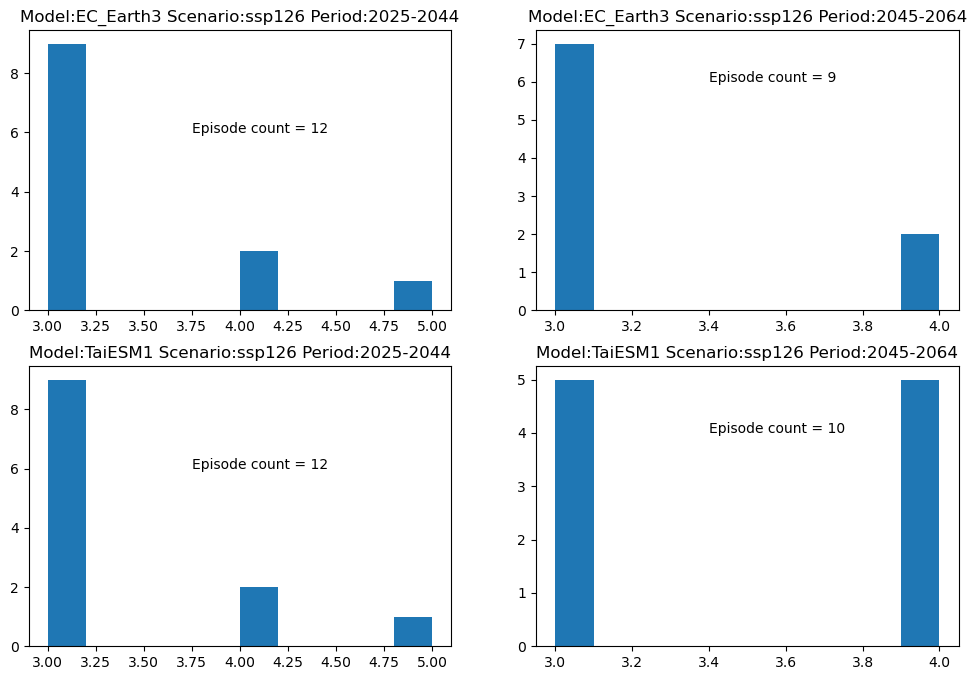

In [34]:
fig, ax = plt.subplots(2,2,figsize=(12,8))

ax[0,0].hist(severity_EC_Earth3_ssp126_2544)
ax[0,1].hist(severity_EC_Earth3_ssp126_4564)
ax[1,0].hist(severity_TaiESM1_ssp126_2544)
ax[1,1].hist(severity_TaiESM1_ssp126_4564)

ax[0,0].set_title('Model:EC_Earth3 Scenario:ssp126 Period:2025-2044')
ax[0,1].set_title('Model:EC_Earth3 Scenario:ssp126 Period:2045-2064')
ax[1,0].set_title('Model:TaiESM1 Scenario:ssp126 Period:2025-2044')
ax[1,1].set_title('Model:TaiESM1 Scenario:ssp126 Period:2045-2064')

ax[0,0].text(3.75,6,f'Episode count = {episodes_EC_Earth3_ssp126_2544[-1]}')
ax[0,1].text(3.4,6,f'Episode count = {episodes_EC_Earth3_ssp126_4564[-1]}')
ax[1,0].text(3.75,6,f'Episode count = {episodes_TaiESM1_ssp126_2544[-1]}')
ax[1,1].text(3.4,4,f'Episode count = {episodes_TaiESM1_ssp126_4564[-1]}')

plt.show()